In [33]:
from datasets import Image as Img
from datasets import Features, Sequence, ClassLabel, Value, Dataset
from PIL import Image, ImageDraw

# Приведение данных в требуемый вид

In [34]:
test_size = 0.2
path_to_data = 'data\\ubiai_dataset\\58ae6df1-036a-4a0f-87db-527140434007'
valid_ner_tags = [
    'O','B-DATE','I-DATE','E-DATE','S-DATE',
    'B-FULL_NAME','I-FULL_NAME','E-FULL_NAME','S-FULL_NAME',
    'B-DOC_TYPE','I-DOC_TYPE','E-DOC_TYPE','S-DOC_TYPE',
    'B-PLACE','I-PLACE','E-PLACE','S-PLACE',
    'B-REASON_OBTAINING','I-REASON_OBTAINING','E-REASON_OBTAINING','S-REASON_OBTAINING'
]

def read_text_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return (f.readlines())
   
files = {}

files['train_box'] = read_text_file(f'{path_to_data}_box.txt')
files['train_image'] = read_text_file(f'{path_to_data}_image.txt')
files['train'] = read_text_file(f'{path_to_data}.txt')

assert(len(files['train']) == len(files['train_box']))
assert(len(files['train_box']) == len(files['train_image']))
assert(len(files['train_image']) == len(files['train']))

# Словарь images - последовательная нумерация слов в каждом изображении
images = {}
for i, row in enumerate(files['train_image']):
    if row != '\n':
        image_name = row.split('\t')[-1]
        images.setdefault(image_name.replace('\n', ''), []).append(i)

words, bboxes, ner_tags, image_path = [], [], [], []
for image, rows in images.items():
    words.append(
        [
            row.split('\t')[0].replace('\n', '')
            for row in files['train'][rows[0]:rows[-1]+1]
        ]
    )

    # Оставляем только те теги, которые модель успешно классифицирует
    ner_tags.append(
        [
            row.split('\t')[1].replace('\n', '')
            if row.split('\t')[1].replace('\n', '') in valid_ner_tags
            else 'O'
            for row in files['train'][rows[0]:rows[-1]+1]

        ]
    )
    bboxes.append(
        [
            box.split('\t')[1].replace('\n', '')
            for box in files['train_box'][rows[0]:rows[-1]+1]
        ]
    )
    image_path.append(f'data\\ubiai_dataset\\{image}')

# Уникальные ner-теги и словари id:тег, тег:id
labels = list(set([tag for doc_tag in ner_tags for tag in doc_tag]))
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

# Приводим датасет в требуемый для модели вид
## Для bboxes исправляем ошибку с элементами, выходящими за рамки изображения
dataset_dict = {
    'id': range(len(words)),
    'words': words,
    'bboxes': [[[int(el) if int(el) <=1000 else 1000 for el in bbox.split()] for bbox in doc] for doc in bboxes],
    'ner_tags': [[label2id[tag] for tag in ner_tag] for ner_tag in ner_tags],
    'image': [Image.open(path).convert('RGB') for path in image_path],
    'path': image_path
}

features = Features({
    'id': Value(dtype='string', id=None),
    'words': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'ner_tags': Sequence(feature=ClassLabel(num_classes=len(labels), names=labels, names_file=None, id=None), length=-1, id=None),
    'image': Img(decode=True, id=None),
    'path': Value(dtype='string', id=None),
})

dataset = Dataset.from_dict(dataset_dict, features=features)
dataset = dataset.train_test_split(test_size=test_size, seed=1)

dataset.save_to_disk('data\\raw_data')

Saving the dataset (1/1 shards): 100%|██████████| 43/43 [00:00<00:00, 164.22 examples/s]


Колташев Я_image_0.jpg  
Колташев Я А _image_0.jpg  
Агапитов Д_image_0.jpg  
Агапитов Д В  (1)_image_0.jpg


# Проверки и дебаг

In [35]:
for i,el in enumerate(dataset['train']):
    if '40_' in el['path'] or 'СПБ' in el['path']:
        print(i,el)

79 {'id': '126', 'words': ['СЕРТИФИКАТ', 'УЧАСТНИКА', 'ВРУЧАЕТСЯ:', 'Шишкиной', 'Екатерине', 'ДОРОГА', 'ТЯЖЕЛА,', 'НО', 'ТЫ', 'ДОБРАЛСЯ(АСЬ)', 'ДАЛЕКО.', 'НЕ', 'ВРЕМЯ', 'ОСТАНАВЛИВАТЬСЯ!', 'БУДЬ', 'ДЕРЗКИМ', 'И', 'ТЫ', 'ДОБЬЕШЬСЯ', 'СВОЕГО!', 'МИНИСТР', 'ПО', 'ФИЗИЧЕСКОЙ', 'КУЛЬТУРЕ,', 'СПОРТУ', 'И', 'МОЛОДЕЖНОЙ', 'ПОЛИТИКЕ', 'УДМУРТСКОЙ', 'РЕСПУБЛИКИ', 'NoojO', 'КРАСНОВ', 'И.В.', 'ЧЕВСК', 'МЕХРАКОНИ', 'ГЕНЕРАЛЬНЫЙ', 'ДИРЕКТОР', 'РЕСПУБЛИКАНСКОГО', 'ФОРУМА', '«ДОСТОЯНИЕ', 'РЕСПУБЛИКИ»', 'Креативный', 'AHма', 'ДОСТОЯНИЕ', 'ИНН', '1834045441', '*', '6', 'РЕСПУБЛИКИ', 'ОГРН', '108', 'МИХАЙЛОВ', 'А.В.', 'Креативный', '*', 'ЛИОТ', 'на', 'фные', 'статурыере.', 'капитал', 'ШЭб', 'ГОРОДЕ', 'чик', 'проск', 'ід'], 'bboxes': [[77, 62, 414, 88], [95, 94, 396, 119], [109, 193, 232, 204], [154, 314, 329, 342], [154, 361, 329, 392], [111, 444, 176, 457], [189, 444, 276, 456], [282, 444, 305, 456], [317, 444, 335, 456], [109, 459, 259, 469], [268, 459, 346, 469], [109, 471, 129, 482], [141, 472, 200, 

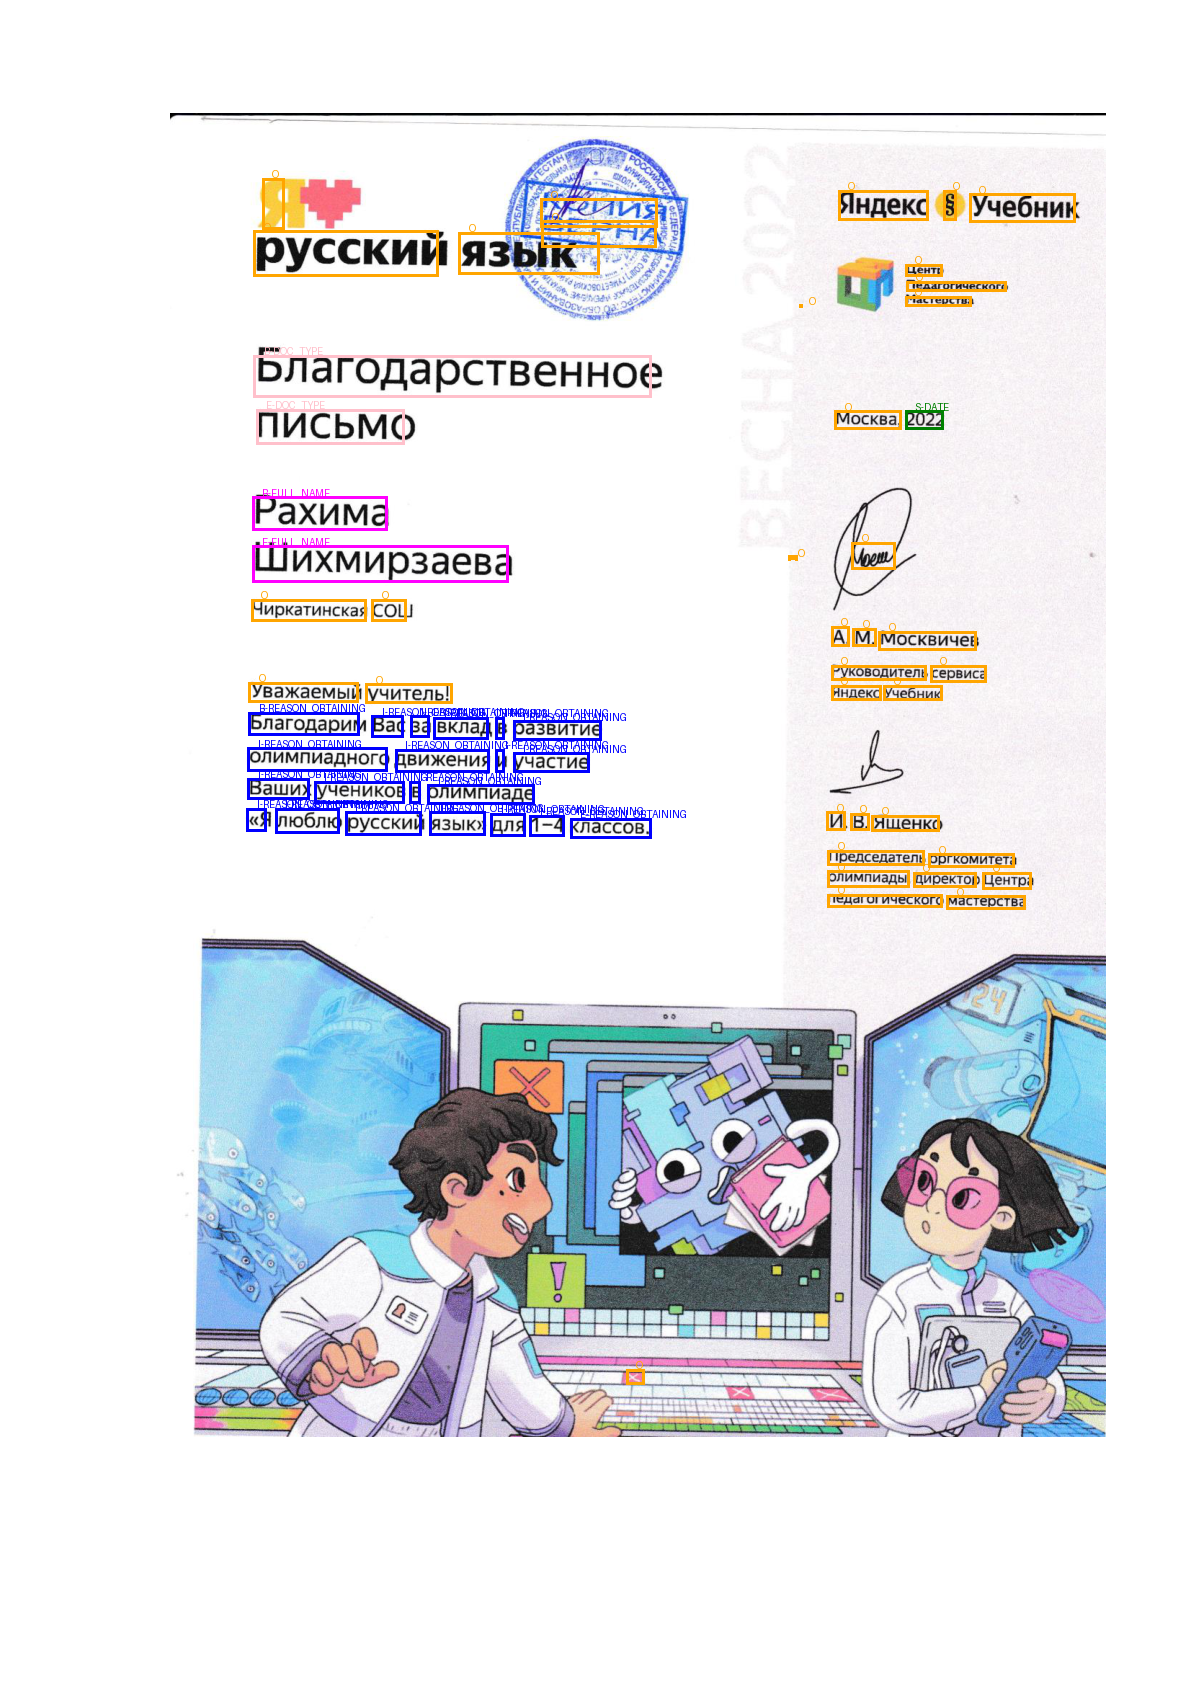

In [41]:
label2color = {
    'B-DATE': 'green',
    'B-DOC_TYPE': 'pink',
    'B-PLACE': 'yellow',
    'B-FULL_NAME': 'magenta',
    'B-REASON_OBTAINING': 'blue',
    'E-DATE': 'green',
    'E-DOC_TYPE': 'pink',
    'E-PLACE': 'yellow',
    'E-FULL_NAME': 'magenta',
    'E-REASON_OBTAINING': 'blue',
    'I-DATE': 'green',
    'I-DOC_TYPE': 'pink',
    'I-PLACE': 'yellow',
    'I-FULL_NAME': 'magenta',
    'I-REASON_OBTAINING': 'blue',
    'S-DATE': 'green',
    'S-DOC_TYPE': 'pink',
    'S-PLACE': 'yellow',
    'S-FULL_NAME': 'magenta',
    'S-REASON_OBTAINING': 'blue',
    'O': 'orange',
}

def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]

def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    draw = ImageDraw.Draw(image)

    for prediction, box in zip(predictions, normalizes_boxes):
        draw.rectangle(box, outline=label2color[prediction], width=3)
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction])
    return image


def word_indices(bbox_list):
    '''
    Функция для очистки индексов от предсказаний по лишним токенам.
    Модель предоставляет предсказаня для токенов на уровне символов, 
    а требуются предсказания на уровне слов.
    '''

    occurrences = []
    indices = []
    for i, bbox in enumerate(bbox_list):
        if bbox not in occurrences and bbox != [0, 0, 0, 0]:
            occurrences.append(bbox)
            indices.append(i)
            
    return indices


# for i in range(20):
#     labels = [id2label[teg] for teg in dataset['train'][i]['ner_tags']]
#     display(draw_boxes(dataset['train'][i]['image'], dataset['train'][i]['bboxes'], labels))

labels = [id2label[teg] for teg in dataset['train'][140]['ner_tags']]
display(draw_boxes(dataset['train'][140]['image'], dataset['train'][140]['bboxes'], labels))